## *Hmong Opium Package*

![](PXL_20240613_105950267.jpg){ fig-align="center" width="60%"}

In [1]:
import torch
import pyro

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# this is just a definition of a function that we will be using for sampling from the model and 
# creating plots of the samples

def plot_from_nodes(nodes, filters: Dict[str, float] = None, nodes_to_plot: List[str] = None, bins = 20):

    """
   The plot_from_nodes function takes a dictionary of nodes, processes their values, optionally filters the data,
    and plots histograms for specified nodes. The function then returns the processed DataFrame.
    Parameters:
    - nodes: Dictionary of nodes containing data.
    - filters: Optional dictionary to filter the data based on specified conditions.
    - nodes_to_plot: Optional list of specific nodes to plot. If not provided, plots all nodes.
    - bins: Number of bins for the histograms (default is 20).

    Returns:
    - DataFrame of the processed values.
    """

    values = {key: nodes[key]['value'].float().detach().cpu().numpy() for key in nodes.keys() if nodes[key]['name'] != 'samples'}

    valuesDF = pd.DataFrame(values)

    if filters is not None:
        for key in filters.keys():
            valuesDF = valuesDF[valuesDF[key] == filters[key]]

    if nodes_to_plot is None:
        nodes_to_plot = values.keys()

    for key in nodes_to_plot:
        plt.figure()
        plt.hist(valuesDF[key], bins=bins, alpha=0.7, color='blue', density=True)
        plt.title(f"{key}, mean: {valuesDF[key].mean()}")
        plt.xlabel('value')
        plt.ylabel('frequency')
        sns.despine()
        plt.show()  

    return valuesDF

In [3]:
def weight(posterior: List[float], base = 2) -> float:

    grid_length = len(posterior)
    x = np.linspace(0, 1, grid_length)
    uniform = beta.pdf(x, 1, 1) # def. of a uniform distribution given the size of the posterior
    
    entropy_uniform = entropy(uniform, base=base) # entropy H(uniform)
    entropy_posterior = entropy(posterior, base=base) # entropy H(p)
    return 1 - entropy_posterior/entropy_uniform # weight = 1 - H(p)/H(uniform)


The first model represents the RMP that a random person from population of Minneapolis (1992) is a smuggler given that they received a package, with the division on Hmong and not Hmong.

  # Sample whether the person is Hmong

  pr_Hmong = 0.06
    pr_Hmong_if_smuggler = 0.95
    pr_smuggler = 0.005
    pr_package = 0.006

    is_hmong = pyro.sample("is_hmong", dist.Bernoulli(pr_Hmong))
    
    # Sample whether the person is a smuggler
    is_smuggler = pyro.sample("is_smuggler", dist.Bernoulli(pr_smuggler))
    
    # Update the probability of being Hmong given that the person is a smuggler
    pr_hmong_if_smuggler_updated = is_smuggler * pr_Hmong_if_smuggler + (1 - is_smuggler) * pr_Hmong
    
    # Sample whether the person is Hmong given they are a smuggler
    is_hmong_if_smuggler = pyro.sample("is_hmong_if_smuggler", dist.Bernoulli(pr_hmong_if_smuggler_updated))
    

    pr_package_if_smuggler = 0.95
        actual_pr_package = is_smuggler * pr_package_if_smuggler + (1 - is_smuggler) * pr_package
        
        # Sample whether the person receives a package
        has_package = pyro.sample("has_package", dist.Bernoulli(actual_pr_package))


  pr_smuggler_if_package = (pr_smuggler * pr_package_if_smuggler) / (
        pr_smuggler * pr_package_if_smuggler + (1 - pr_smuggler) * pr_package)

In [4]:
0.006 / 0.005


1.2

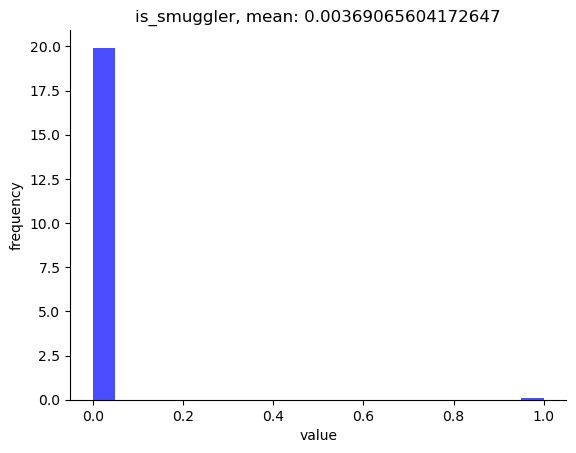

,data,is_hmong,is_smuggler,is_hmong_if_smuggler,has_package
4,4.0,1.0,0.0,0.0,0.0
25,25.0,1.0,0.0,0.0,0.0
37,37.0,1.0,0.0,0.0,0.0
43,43.0,1.0,0.0,0.0,0.0
64,64.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
99920,99920.0,1.0,0.0,0.0,0.0
99922,99922.0,1.0,0.0,0.0,0.0
99939,99939.0,1.0,0.0,0.0,0.0
99943,99943.0,1.0,0.0,0.0,0.0


In [20]:
def opium_package_general():

    

    pr_Hmong = 0.06
    pr_Hmong_if_smuggler = 0.95
    pr_smuggler = 0.005
    pr_package = 0.006

    is_hmong = pyro.sample("is_hmong", dist.Bernoulli(pr_Hmong))
    
    # Sample whether the person is a smuggler
    is_smuggler = pyro.sample("is_smuggler", dist.Bernoulli(pr_smuggler))
    
    # Update the probability of being Hmong given that the person is a smuggler
    pr_hmong_if_smuggler_updated = is_smuggler * pr_Hmong_if_smuggler + (1 - is_smuggler) * pr_Hmong
    
    # Sample whether the person is Hmong given they are a smuggler
    is_hmong_if_smuggler = pyro.sample("is_hmong_if_smuggler", dist.Bernoulli(pr_hmong_if_smuggler_updated))
    

    pr_package_if_smuggler = 0.95
    actual_pr_package = is_smuggler * pr_package_if_smuggler + (1 - is_smuggler) * pr_package
        
        # Sample whether the person receives a package
    has_package = pyro.sample("has_package", dist.Bernoulli(actual_pr_package))



    pr_smuggler_if_package = (pr_smuggler * pr_package_if_smuggler) / (
        pr_smuggler * pr_package_if_smuggler + (1 - pr_smuggler) * pr_package)



    # package = pyro.sample("package", dist.Bernoulli(prob_package))
    # smuggler = pyro.sample("smuggler", dist.Bernoulli(prob_smuggler))
    




# Render the model to visualize its structure
pyro.render_model(opium_package_general)

# Trace the execution of the model with 100,000 data points
with pyro.poutine.trace() as tr:
    with pyro.plate("data", 100000):
        opium_package_general()

# Extract the nodes from the trace
nodes = tr.trace.nodes

# Plot the specified nodes, filtering for cases where fingers == 1.0, for that records we look at the probability of missing fingers if Swedish
# and the probability of being guilty
plot_from_nodes(nodes, 
                filters={'is_hmong': 1.0},
                 nodes_to_plot=[ "is_smuggler"])

# This function also returns a DataFrame of the processed values
